In [1]:
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
import plotly.graph_objects as go 
import time 

In [2]:
# Hide notebook warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
import sys
sys.path.append('./reu')

from easyGPR_helper import set_gpytorch_settings, GPRModel

set_gpytorch_settings()

## The Levy Function (N.13)

More info: [https://www.sfu.ca/~ssurjano/levy13.html](https://www.sfu.ca/~ssurjano/levy13.html)

The **Levy function** is commonly used to test optimization algorithms due to its complex landscape full of local minima.

$$
f(\mathbf{x}) = \sin^2(3\pi x_1) + (x_1 - 1)^2 \left[1 + \sin^2(3\pi x_2)\right] + (x_2 - 1)^2 \left[1 + \sin^2(2\pi x_2)\right]
$$



In [4]:
import numpy as np

# ---- tweakable parameters ----
x1_min, x1_max = -10, 10       # domain limits for x1
x2_min, x2_max = -10, 10       # domain limits for x2
n_x1 = 100                     # number of points in x1 for visual
n_x2 = 100                     # number of points in x2 for visual
# -------------------------------

def test_function(x1, x2):  # NumPy version of Levy13
    w1 = 1 + (x1 - 1) / 4
    w2 = 1 + (x2 - 1) / 4
    term1 = np.sin(np.pi * w1) ** 2
    term2 = ((w1 - 1) ** 2) * (1 + 10 * np.sin(np.pi * w1 + 1) ** 2)
    term3 = ((w2 - 1) ** 2) * (1 + np.sin(2 * np.pi * w2) ** 2)
    return term1 + term2 + term3

# grid
x1 = np.linspace(x1_min, x1_max, n_x1)
x2 = np.linspace(x2_min, x2_max, n_x2)
X1, X2 = np.meshgrid(x1, x2)
y = test_function(X1, X2)  # output surface

## Contour HeatMap Visualization

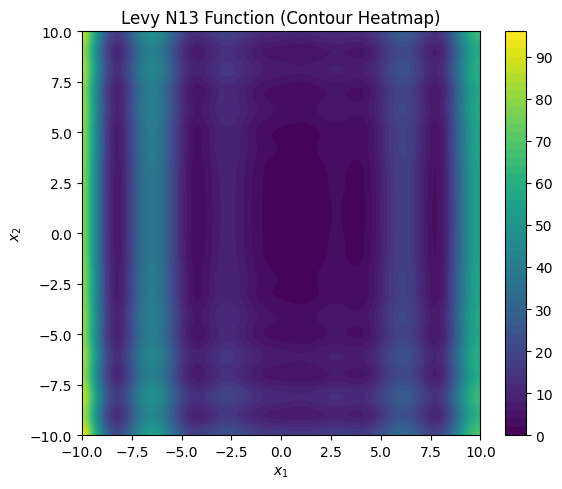

In [5]:
fig, ax = plt.subplots(figsize=(6, 5))
cntr = ax.contourf(X1, X2, y, levels=50, cmap='viridis')
fig.colorbar(cntr, ax=ax)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_title('Levy N13 Function (Contour Heatmap)')
plt.tight_layout()
plt.show()


## Static 3-D Surface Visualization 

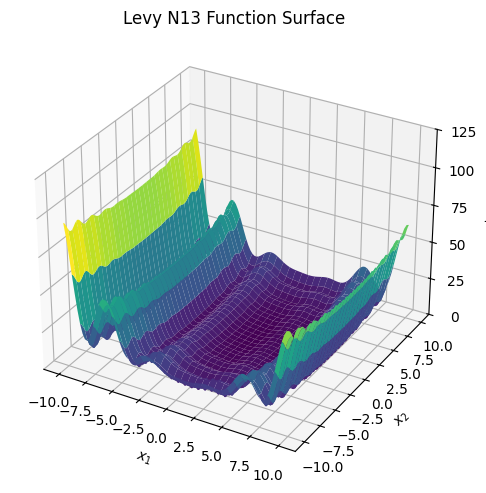

In [6]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X1, X2, y, rstride=3, cstride=3, cmap='viridis',
                       linewidth=0, antialiased=True)

# Label axes
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_zlabel(r'$y$')
ax.set_title('Levy N13 Function Surface')

# Set Z ticks and format
ax.set_zlim(0, 125)
ax.set_zticks([0, 25, 50, 75, 100, 125])


plt.tight_layout()
plt.show()

## Interactable 3-D Surface 

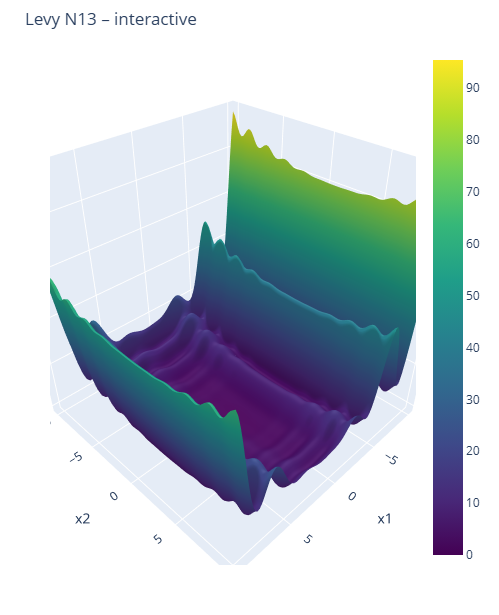

In [7]:
fig = go.Figure(
    data=[go.Surface(x=X1, y=X2, z=y, colorscale='Viridis', showscale=True)]
)
fig.update_layout(title='Levy N13 – interactive',
                  scene=dict(xaxis_title='x1',
                             yaxis_title='x2',
                             zaxis_title='y'),
                  width=750, height=600,
                  margin=dict(l=50, r=50, b=50, t=50))
fig.show()

In [8]:
import matplotlib as mpl
# Base font size for text
mpl.rcParams['font.size']         = 14   
# Axis titles
mpl.rcParams['axes.titlesize']    = 16   
# Axis labels (x/y/z)
mpl.rcParams['axes.labelsize']    = 14   
# Tick‐label size
mpl.rcParams['xtick.labelsize']   = 12   
mpl.rcParams['ytick.labelsize']   = 12   
# Legend (if any)
mpl.rcParams['legend.fontsize']   = 12   
# Figure title (supertitle)
mpl.rcParams['figure.titlesize']  = 18   


## Fit GP to Levy13 Function

In [9]:
def test_function(x):  # Levy13 Function
    x1 = x[:, 0]
    x2 = x[:, 1]

    w1 = 1 + (x1 - 1) / 4
    w2 = 1 + (x2 - 1) / 4

    term1 = np.sin(np.pi * w1) ** 2
    term2 = ((w1 - 1) ** 2) * (1 + 10 * np.sin(np.pi * w1 + 1) ** 2)
    term3 = ((w2 - 1) ** 2) * (1 + np.sin(2 * np.pi * w2) ** 2)

    return term1 + term2 + term3

## Data Generation

In [10]:
# ---- tweakable parameters ----
x1_min_train, x1_max_train = -4.5, 4.5      # domain limits for x1
x2_min_train, x2_max_train = -4.5, 4.5      # domain limits for x2
n_x1_train = 10                     # number of points in x1 for visual
n_x2_train = 10                      # number of points in x2 for visual
# --------------------------------

print(f"Total number of training points: {n_x1_train} * {n_x2_train} = {n_x1_train * n_x2_train}")


# grid
x1_train = np.linspace(x1_min_train, x1_max_train, n_x1_train)
x2_train = np.linspace(x2_min_train, x2_max_train, n_x2_train)
X1_train, X2_train = np.meshgrid(x1_train, x2_train)

x_train = np.column_stack((X1_train.flatten(), X2_train.flatten()))
y_train = test_function(x_train)              


# add noise (optional)
sigma = 0.1  # set to 0 to turn off
if sigma > 0:
    rng = np.random.default_rng(42)  # for reproducibility
    y_train += rng.normal(0, sigma, size = y_train.shape)

Total number of training points: 10 * 10 = 100


In [23]:
import sys
sys.path.append('./reu')
from linear_operator.operators import MatmulLinearOperator as MatmulLazyTensor, RootLinearOperator as RootLazyTensor



from kernels import RBFNonSeparableKernel, MaternNonSeparableKernel
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel, RQKernel, PeriodicKernel


# SE is same as RBF
k1 = ScaleKernel(
    RBFKernel(ard_num_dims=2)
)
# Matern Non Separable Kernel
k2 = ScaleKernel(
    MaternNonSeparableKernel(ard_num_dims=2)
)
# Matern 5/2
k3 = ScaleKernel(MaternKernel(nu=2.5, ard_num_dims=2))

#Rational Quadratic
k4 = ScaleKernel(RQKernel(ard_num_dims=2))

#Combined Periodic + RBF Kernel
k5 = ScaleKernel(PeriodicKernel(active_dims=[0]) + PeriodicKernel(active_dims=[1]) + RBFKernel())


# Define the GPR model with the kernels
m1 = GPRModel(train_x=x_train, train_y=y_train, kernel=k1)
m2 = GPRModel(train_x=x_train, train_y=y_train, kernel=k2, scale_x = False)
m3 = GPRModel(train_x=x_train, train_y=y_train, kernel=k3, scale_x = False) 
m4 = GPRModel(train_x=x_train, train_y=y_train, kernel=k4)
m5 = GPRModel(train_x=x_train, train_y=y_train, kernel=k5)

print("RBF")
t0 = time.perf_counter()
m1.fit_model(training_iterations=200, lr=0.1)
elapsed = time.perf_counter() - t0
print(f"Training took {elapsed:.2f} s")


print("Matern Non Separable")
t0 = time.perf_counter()
m2.fit_model(training_iterations=200, lr=0.1)
elapsed2 = time.perf_counter() - t0
print(f"training took {elapsed2:.2f} s")

print("Matern 5/2")
t0 = time.perf_counter()
m3.fit_model(training_iterations=200, lr=0.1)
elapsed3 = time.perf_counter() - t0
print(f"training took {elapsed3:.2f} s")


print("Rational Quadratic")
t0 = time.perf_counter()
m4.fit_model(training_iterations=200, lr=0.1)
elapsed4 = time.perf_counter() - t0
print(f"training took {elapsed4:.2f} s")

print("Periodic + RBF")
t0 = time.perf_counter()
m5.fit_model(training_iterations=75, verbose=True, lr=0.1)
elapsed5 = time.perf_counter() - t0
print(f"training took {elapsed5:.2f} s")

RBF
Fitting complete.
--- 
--- final mll: 0.1303
--- num_params: 5
--- BIC: -1.5621
Training took 2.95 s
Matern Non Separable
Fitting complete.
--- 
--- final mll: -0.0196
--- num_params: 6
--- BIC: 15.7408
training took 5.27 s
Matern 5/2
Fitting complete.
--- 
--- final mll: -0.1074
--- num_params: 5
--- BIC: 22.1616
training took 4.46 s
Rational Quadratic
Fitting complete.
--- 
--- final mll: 0.1034
--- num_params: 6
--- BIC: 3.4229
training took 4.53 s
Periodic + RBF
Fitting complete.
--- 
--- final mll: 0.5429
--- num_params: 8
--- BIC: -36.0299
training took 2.64 s


In [24]:
from IPython.display import display

print("RBF")
display(m1.get_hyperparameters_df())

print("Matern Non Separable")
display(m2.get_hyperparameters_df())

print("Matern 5/2")
display(m3.get_hyperparameters_df())

print("Rational Quadratic")
display(m4.get_hyperparameters_df())

print("Periodic + RBF")
display(m5.get_hyperparameters_df())


RBF


,Hyperparameter Name,Estimate
0,likelihood.noise_covar.noise,0.005126
1,mean_module.constant,7.608550
2,kernel.outputscale,6.116764
3,kernel.base_kernel.lengthscale,0.129312
4,kernel.base_kernel.lengthscale,0.808759


Matern Non Separable


,Hyperparameter Name,Estimate
0,likelihood.noise_covar.noise,0.004152
1,mean_module.constant,6.286915
2,kernel.outputscale,5.161105
3,kernel.base_kernel.a,0.409928
4,kernel.base_kernel.c,0.012630
5,kernel.base_kernel.rho,0.004750


Matern 5/2


,Hyperparameter Name,Estimate
0,likelihood.noise_covar.noise,0.003816
1,mean_module.constant,5.015063
2,kernel.outputscale,3.382782
3,kernel.base_kernel.lengthscale,1.321939
4,kernel.base_kernel.lengthscale,6.608675


Rational Quadratic


,Hyperparameter Name,Estimate
0,likelihood.noise_covar.noise,0.004994
1,mean_module.constant,7.895733
2,kernel.outputscale,6.273000
3,kernel.base_kernel.lengthscale,0.137294
4,kernel.base_kernel.lengthscale,0.837366
5,kernel.base_kernel.alpha,5.991792


Periodic + RBF


,Hyperparameter Name,Estimate
0,likelihood.noise_covar.noise,0.005220
1,mean_module.constant,3.984953
2,kernel.outputscale,3.345068
3,kernel.base_kernel.kernels.0.lengthscale,0.302169
4,kernel.base_kernel.kernels.0.period_length,1.104690
5,kernel.base_kernel.kernels.1.lengthscale,3.584913
6,kernel.base_kernel.kernels.1.period_length,2.064349
7,kernel.base_kernel.kernels.2.lengthscale,2.316652


## Plotting 
## Get true Function Values

In [17]:
# ---- tweakable parameters ----
x1_min_eval, x1_max_eval = -4.5, 4.5      # domain limits for x1
x2_min_eval, x2_max_eval = -4.5, 4.5      # domain limits for x2
n_x1_eval = 200                      # number of points in x1 for visual
n_x2_eval = 200                      # number of points in x2 for visual
# --------------------------------

print(f"Total number of training points: {n_x1_eval} * {n_x2_eval} = {n_x1_eval * n_x2_eval}")


# grid
x1_eval = np.linspace(x1_min_eval, x1_max_eval, n_x1_eval)
x2_eval = np.linspace(x2_min_eval, x2_max_eval, n_x2_eval)
X1_eval, X2_eval = np.meshgrid(x1_eval, x2_eval)

x_eval = np.column_stack((X1_eval.flatten(), X2_eval.flatten()))
y_eval = test_function(x_eval)    

Total number of training points: 200 * 200 = 40000


## Make GP Predictions

In [25]:
m1_pred = m1.make_predictions(x_eval).mean
m2_pred = m2.make_predictions(x_eval).mean
m3_pred = m3.make_predictions(x_eval).mean
m4_pred = m4.make_predictions(x_eval).mean
m5_pred = m5.make_predictions(x_eval).mean

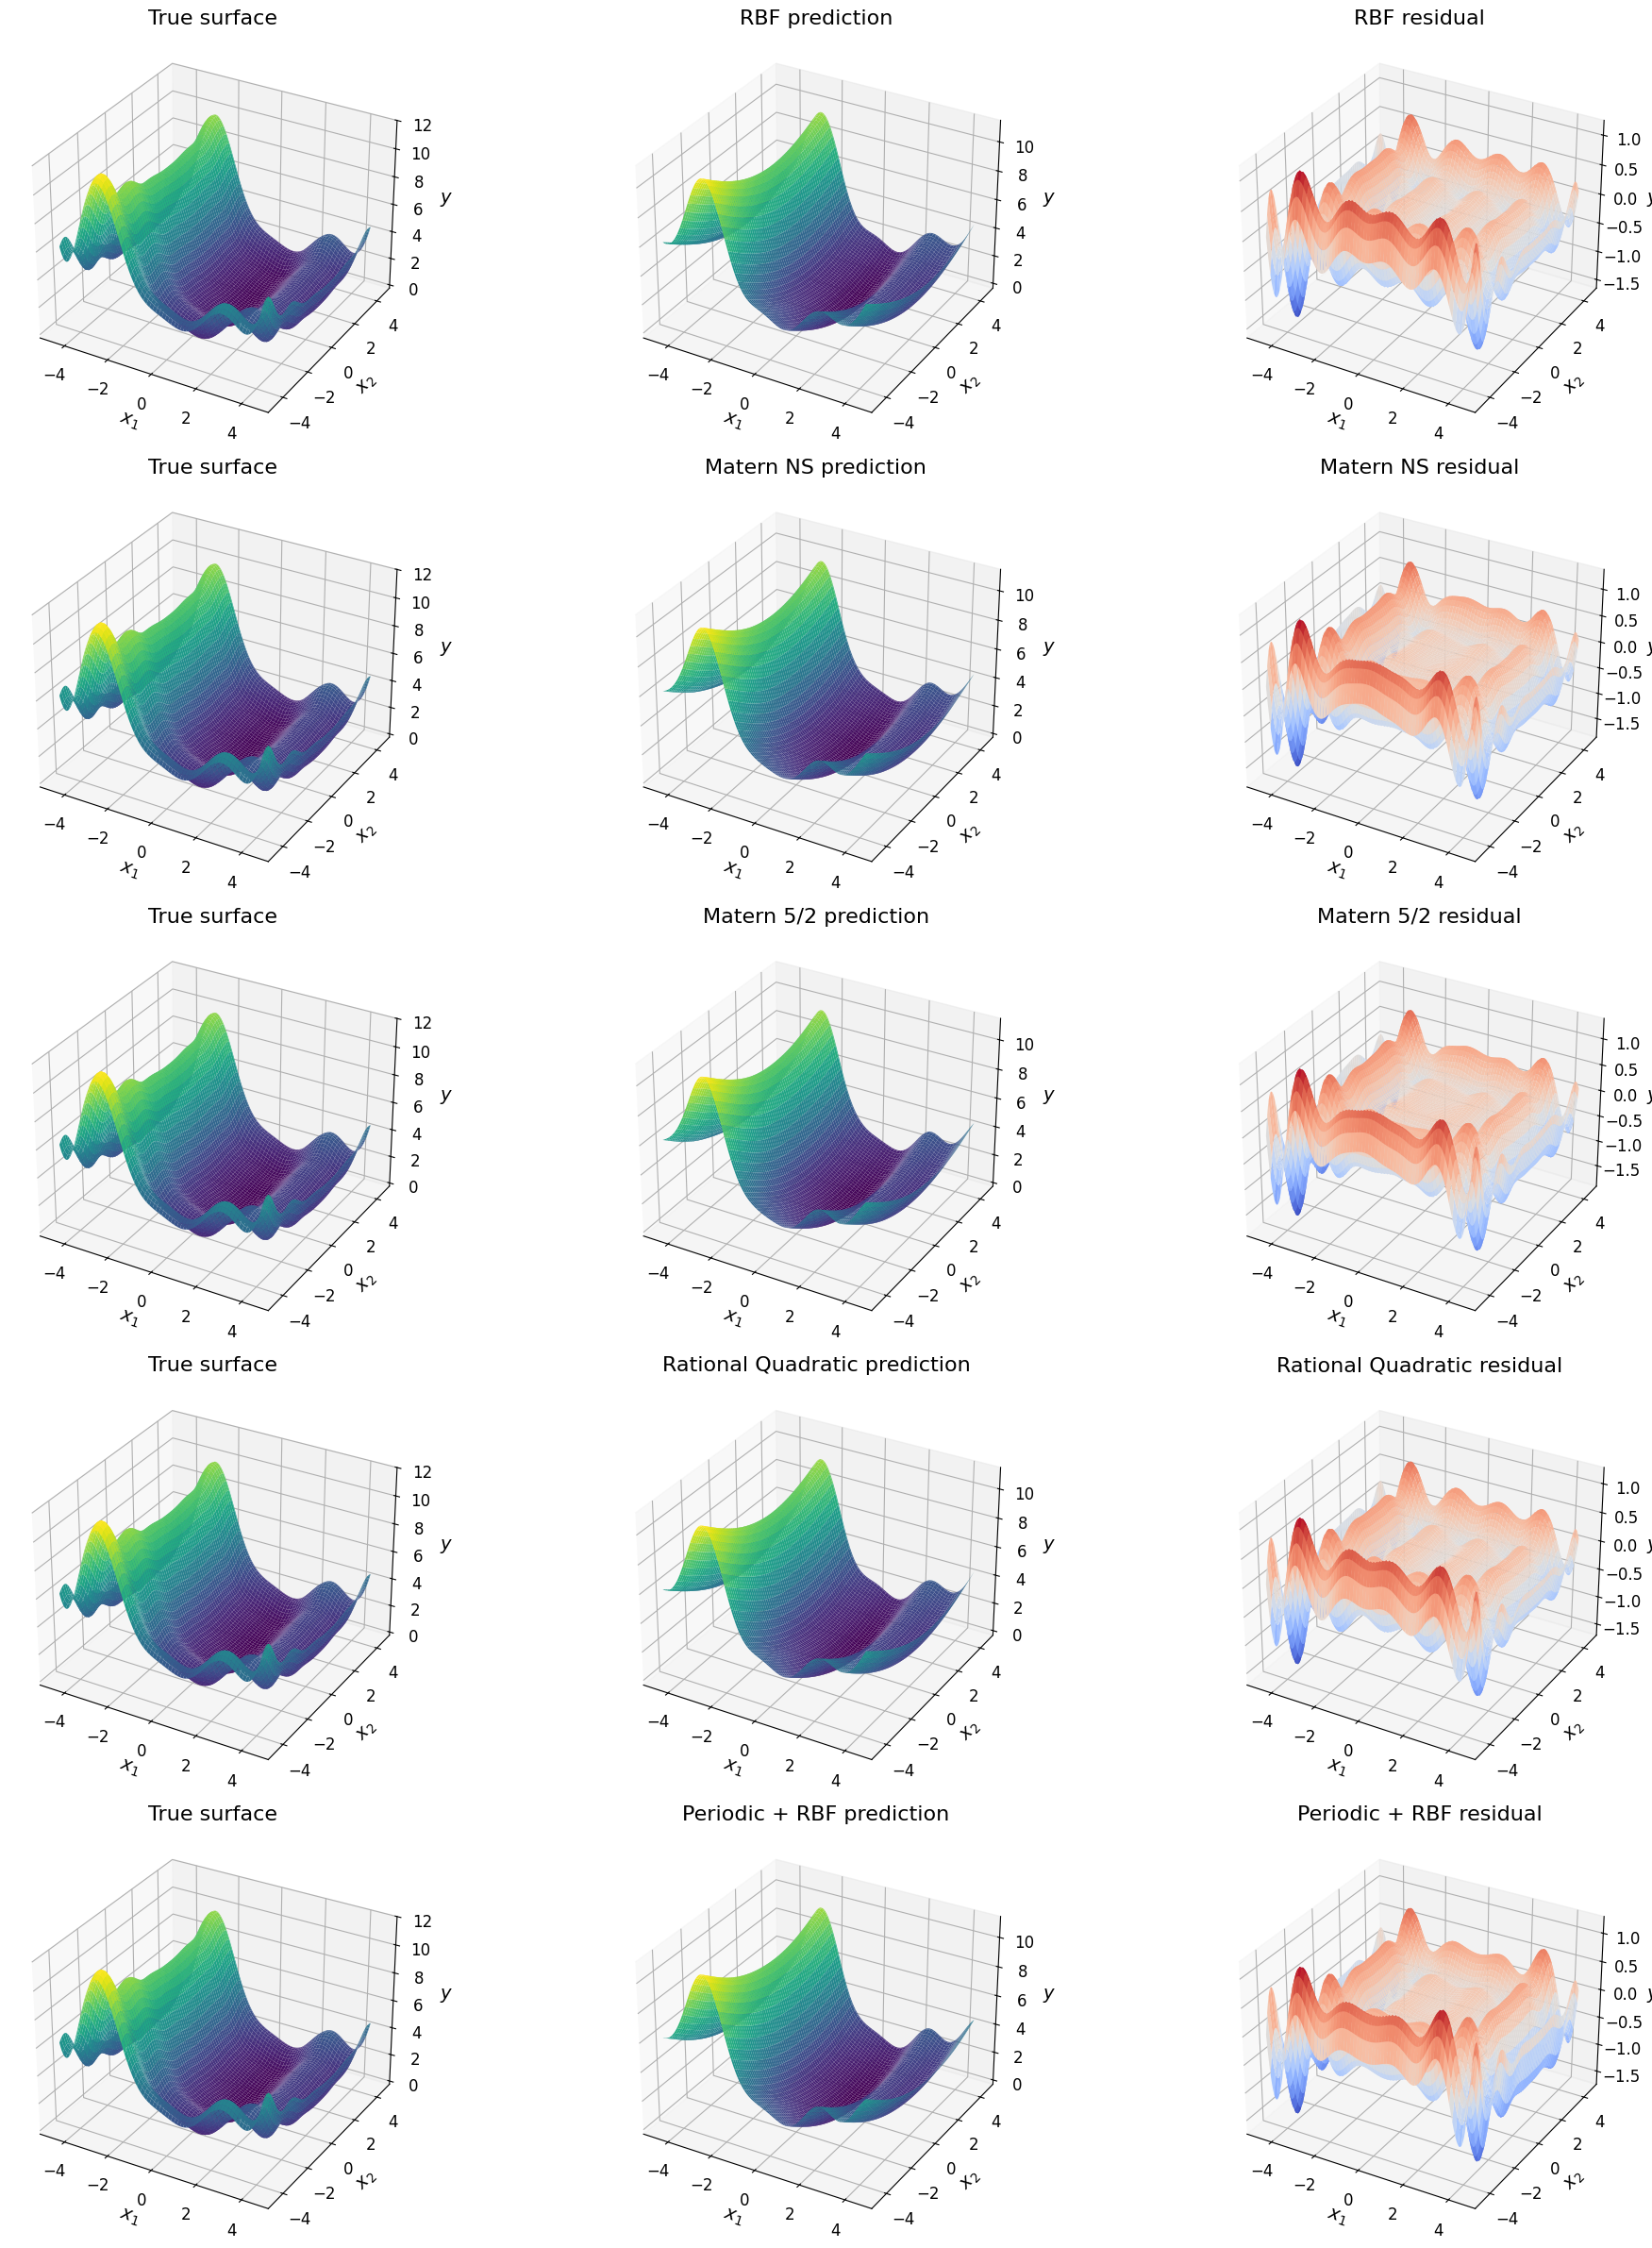

In [26]:
# Reshape for plotting

y_plot = y_eval.reshape(n_x2_eval, n_x1_eval)
m1_plot = m1_pred.reshape(n_x2_eval, n_x1_eval)
m2_plot = m2_pred.reshape(n_x2_eval, n_x1_eval)
m3_plot = m3_pred.reshape(n_x2_eval, n_x1_eval)
m4_plot = m4_pred.reshape(n_x2_eval, n_x1_eval)
m5_plot = m5_pred.reshape(n_x2_eval, n_x1_eval)
models = [
    ('RBF', m1_plot),
    ('Matern NS', m2_plot),
    ('Matern 5/2', m3_plot),
    ('Rational Quadratic', m4_plot),
    ('Periodic + RBF', m5_plot)
]

# Set up 5×3 subplot grid
fig, axes = plt.subplots(len(models), 3,
                         figsize=(21, 24),
                         subplot_kw={'projection': '3d'})

for row, (model_name, pred_plot) in enumerate(models):
    # Define the surfaces for this row
    surfaces = [y_plot, pred_plot, y_plot - pred_plot]
    titles = ['True surface', f'{model_name} prediction', f'{model_name} residual']
    cmaps = ['viridis', 'viridis', 'coolwarm']

    for col in range(3):
        ax = axes[row, col]
        surf = ax.plot_surface(X1_eval, X2_eval, surfaces[col],
                               rstride=3, cstride=3,
                               cmap=cmaps[col],
                               linewidth=0,
                               antialiased=True)
        ax.set_xlabel(r'$x_1$')
        ax.set_ylabel(r'$x_2$')
        ax.set_zlabel(r'$y$')
        ax.set_title(titles[col])

plt.tight_layout()
plt.show()

## Comparing Models

In [27]:
import pandas as pd

results_df = pd.DataFrame({
    'Model': [
        'RBF Kernel (ard_num_dims=2)',
        'Matern Nonseparable Kernel',
        'Matern 5/2',
        'Rational Quadratic',
        'Periodic + RBF Kernel'
    ],
    'BIC': [
        round(m1.bic.item(), 2),
        round(m2.bic.item(), 2),
        round(m3.bic.item(), 2),
        round(m4.bic.item(), 2),
        round(m5.bic.item(), 2)
    ],
    'LOOCV': [
        round(m1.get_LOOCV().item(), 2),
        round(m2.get_LOOCV().item(), 2),
        round(m3.get_LOOCV().item(), 2),
        round(m4.get_LOOCV().item(), 2),
        round(m5.get_LOOCV().item(), 2)
    ]
})

print(results_df)


                         Model    BIC  LOOCV
0  RBF Kernel (ard_num_dims=2)  -1.56   0.10
1   Matern Nonseparable Kernel  15.74   0.12
2                   Matern 5/2  22.16   0.13
3           Rational Quadratic   3.42   0.10
4        Periodic + RBF Kernel -36.03   0.08


<span style="font-size:12px">The Periodic + RBF kernel clearly outperforms the others 
 The RBF and Rational Qaudratic kernels tie for second place in LOOCV (0.10), but their BIC values are significantly worse.
 Matern kernels underperform on both metrics, suggesting they may not capture the function's periodicity and sharp features well.</span>

## Adjusted Kernel

In [30]:


# Kernel: RBF + Matern 5/2 + Rational Quadratic + Periodic (on both x1 and x2)
k6 = ScaleKernel(
    RBFKernel(ard_num_dims=2) +
    MaternKernel(nu=2.5, ard_num_dims=2) +
    RQKernel(ard_num_dims=2) +
    PeriodicKernel(active_dims=[0]) +  # handles sin²(3πx₁)
    PeriodicKernel(active_dims=[1])    # handles sin²(2πx₂)
)

# Define the GPR model with the combined kernel
m6 = GPRModel(train_x=x_train, train_y=y_train, kernel=k6)

# Train the model
t0 = time.perf_counter()

m6.fit_model(training_iterations=200, lr=0.1)

elapsed = time.perf_counter() - t0
print(f"Training took {elapsed:.2f} s")

Fitting complete.
--- 
--- final mll: 0.5577
--- num_params: 14
--- BIC: -23.5461
Training took 7.77 s


In [31]:
m6.get_hyperparameters_df()

,Hyperparameter Name,Estimate
0,likelihood.noise_covar.noise,0.005642
1,mean_module.constant,5.351232
2,kernel.outputscale,5.161528
3,kernel.base_kernel.kernels.0.lengthscale,2.303013
4,kernel.base_kernel.kernels.0.lengthscale,5.767265
5,kernel.base_kernel.kernels.1.lengthscale,6.258923
6,kernel.base_kernel.kernels.1.lengthscale,2.811656
7,kernel.base_kernel.kernels.2.lengthscale,3.294958
8,kernel.base_kernel.kernels.2.lengthscale,5.610253
9,kernel.base_kernel.kernels.2.alpha,5.080623


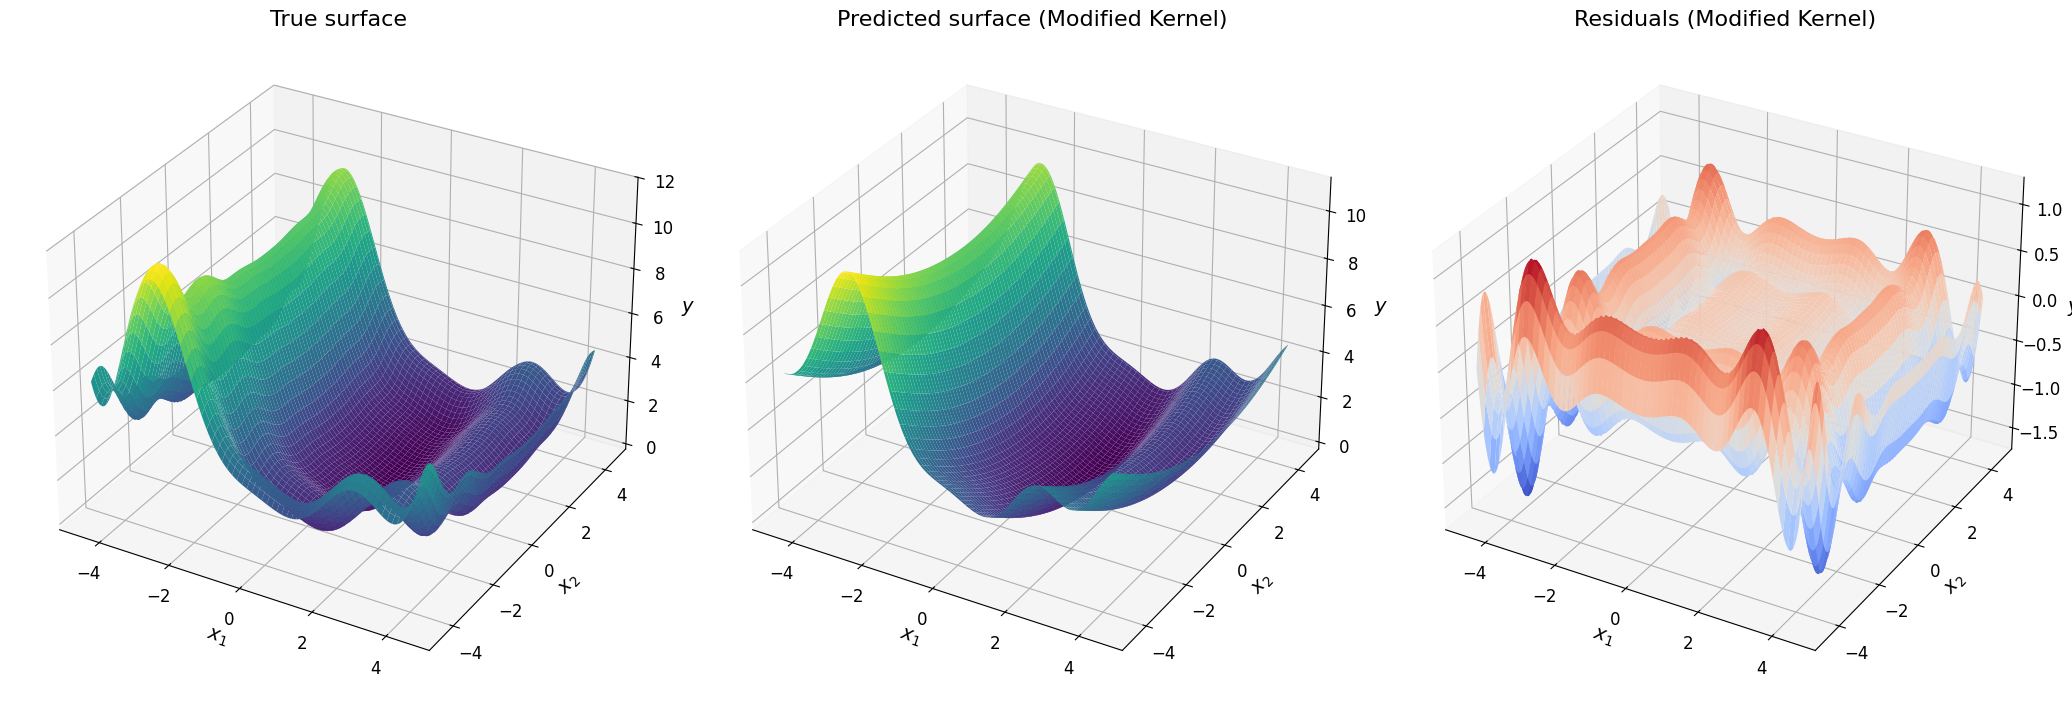

In [32]:
m6_pred = m6.make_predictions(x_eval).mean

# Reshape for plotting

y_plot = y_eval.reshape(n_x2_eval, n_x1_eval)
m6_plot = m6_pred.reshape(n_x2_eval, n_x1_eval)



# set up 1×3 3D plot
fig, axes = plt.subplots(1, 3,
                         figsize=(21, 7),
                         subplot_kw={'projection': '3d'})

for ax, Z, title, cmap in zip(axes,
                              [y_plot, m5_plot, y_plot - m5_plot],
                              ['True surface', 'Predicted surface (Modified Kernel)', 'Residuals (Modified Kernel)'],
                              ['viridis', 'viridis', 'coolwarm']):

    surf = ax.plot_surface(X1_eval, X2_eval, Z,
                           rstride=3, cstride=3,
                           cmap=cmap,
                           linewidth=0,
                           antialiased=True)
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')
    ax.set_zlabel(r'$y$')
    ax.set_title(title)

plt.tight_layout()
plt.show()

## Final Quantitative Comparison

In [34]:
# Build the new row as a dict
new_row = {
    'Model': 'Adjusted Kernel',
    'BIC':   round(m6.bic.item(), 2),
    'LOOCV': round(m6.get_LOOCV().item(), 2)
}

results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

print(results_df)

                         Model    BIC  LOOCV
0  RBF Kernel (ard_num_dims=2)  -1.56   0.10
1   Matern Nonseparable Kernel  15.74   0.12
2                   Matern 5/2  22.16   0.13
3           Rational Quadratic   3.42   0.10
4        Periodic + RBF Kernel -36.03   0.08
5              Adjusted Kernel -23.55   0.08
